In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from data import ProbingDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
ds = ProbingDataset(dir_activations="data_probing/layer_7/", dir_boards="data_probing/")
loader = torch.utils.data.DataLoader(ds, batch_size=256, num_workers=0, pin_memory=True)

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(512, 3*8*8, bias=True)

    def forward(self, x):
        # x : (B, 512)

        # y : (B, 3*8*8)

        return self.fc(x)

In [5]:
probe = MLP().to(device)
optim = torch.optim.AdamW(probe.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.99))

/home/alex/miniconda3/envs/torch23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
losses = []

In [13]:
for i, data in enumerate(loader):
    activations, boards = data
    activations, boards = activations.to(device), boards.to(device)
    boards = boards.long()

    logits = probe(activations)

    loss = F.cross_entropy(logits.view(-1, 3), boards.view(-1), ignore_index=-100)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())

    if i%5000==0:
        print(f"Step {i}. train loss = {loss.item()}")

    if i >= 20000:
        break

Step 0. train loss = 3.409633159637451
Step 5000. train loss = 0.1725928783416748
Step 10000. train loss = 0.1522727608680725
Step 15000. train loss = 0.14101774990558624
Step 20000. train loss = 0.14552803337574005


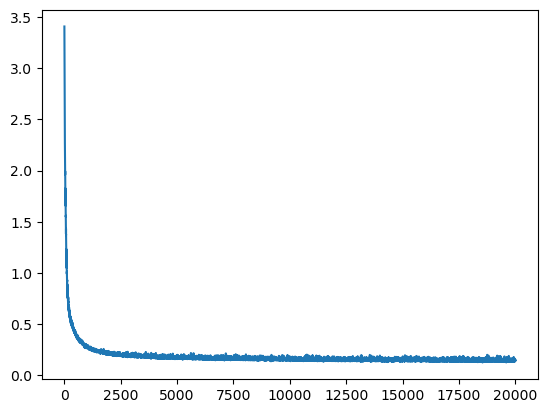

In [14]:
plt.plot(losses)

In [15]:
# eval accuracy (on new data)

In [16]:
from models.transformer.transformer import TransformerConfig
from models.lm import LM

In [20]:
# todo : load from a (future) config file
d_model = 512
n_layers = 8
n_heads = 8

dropout = 0.
bias = False
# todo : load from a (future) config file

# -------------------------------------------------------

config = TransformerConfig(d_model=d_model, n_layers=n_layers, n_heads=n_heads, dropout=dropout, bias=bias, max_len=60, flash=True)
model = LM(config, vocab_size=65).to(device)

checkpoint = torch.load("runs/jumping-plant-20.pth", map_location=device)
model.load_state_dict({key.replace('_orig_mod.', ''): value for key, value in checkpoint['model'].items()}) # todo : plus besoin si unoptimized model stored
print(f"Successfully loaded model from runs/jumping-plant-20.pth.")

model.eval()

Successfully loaded model from runs/jumping-plant-20.pth.


LM(
  (embedding): Embedding(65, 512, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(60, 512)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-7): 8 x DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=512, out_features=512, bias=False)
          (key_proj): Linear(in_features=512, out_features=512, bias=False)
          (value_proj): Linear(in_features=512, out_features=512, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=512, out_features=2048, bias=False)
          (fc_2): Linear(in_features=2048, out_features=512, bias=False)
          (fc_3): Linear(in_features=512, out_features=2048, bias=False)
          (dropout): 

In [21]:
from othello import OthelloGame
import random

In [22]:
n_games = 100

cell_acc = 0
board_acc = 0

for _ in range(n_games): # 100 = num_games
    moves = []
    boards = []

    game = OthelloGame()
    for t in range(60):
        legal_moves = game.get_valid_moves()
        if legal_moves == []:
            break

        move = random.choice(legal_moves)
        game.play_move(move)

        moves.append(move)
        
        board = torch.from_numpy(game.state.copy()).flatten()
        if game.next_hand_color == -1:
            board[board == 1] = 2
            board[board == -1] = 1
        else:
            board[board == -1] = 2
        boards.append(board)

    x = torch.tensor(moves)+1
    x = x.to(device).unsqueeze(0)
    activations = model.forward_up_to(x, 7) # (B=1, 59, d_model)

    preds = torch.argmax(probe(activations).view(-1, 64, 3), dim=-1)[5:-4, :]
    boards = torch.cat(boards).to(device).view(-1, 64)[5:-4, :]

    cell_acc += torch.mean((boards == preds).float()).item() # mean cell accuracy
    board_acc += torch.mean((boards == preds).all(dim=1).float()).item() # mean board accuracy

cell_acc /= n_games
board_acc /= n_games

print(f"{100*cell_acc:.2f}%")
print(f"{100*board_acc:.2f}%")

94.40%
7.58%


In [31]:
# eval accuracy on training data

In [33]:
activations, boards = next(iter(loader))
activations, boards = activations.to(device), boards.to(device)

# mean cell accuracy
cell_acc = torch.mean((boards == torch.argmax(probe(activations).view(-1, 64, 3), dim=-1)).float()).item()
print(100*cell_acc)

# mean board accuracy
board_acc = torch.mean((boards == torch.argmax(probe(activations).view(-1, 64, 3), dim=-1)).all(dim=1).float()).item()
print(100*board_acc)

94.4580078125
10.546875


In [1]:
import torch

In [7]:
A = torch.tensor([[[6, 1], [4, 5], [2, 8]], [[1, 2], [3, 4], [5, 6]]])

In [8]:
A

tensor([[[6, 1],
         [4, 5],
         [2, 8]],

        [[1, 2],
         [3, 4],
         [5, 6]]])

In [9]:
A.storage()

 6
 1
 4
 5
 2
 8
 1
 2
 3
 4
 5
 6
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]

In [5]:
A.size()

torch.Size([3, 2])

In [6]:
A.stride()

(2, 1)

In [10]:
A = torch.tensor([[6, 1], [4, 5], [2, 8]])

In [11]:
B = A.T

In [12]:
B

tensor([[6, 4, 2],
        [1, 5, 8]])

In [17]:
B.data_ptr()

40059520

In [18]:
A.data_ptr()

40059520

In [20]:
A_10 = torch.ones(10, 10)
A_10000 = torch.ones(10000, 10000)

In [23]:
%timeit A_10.T

937 ns ± 14.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [22]:
%timeit A_10000.T

928 ns ± 23.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [29]:
A.storage_offset()

0

In [33]:
A.view(-1).stride()

(1,)

In [35]:
A = torch.tensor([[[6, 1], [4, 5], [2, 8]], [[1, 2], [3, 4], [5, 6]]])
A.size(), A.stride()

(torch.Size([2, 3, 2]), (6, 2, 1))

In [37]:
A.view(6, 2).stride()

(2, 1)

In [41]:
torch.ones(5, 7, 3, 1, 2, 3).stride()

(126, 18, 6, 6, 3, 1)

In [42]:
A = torch.ones(2, 2)

In [46]:
B = A.T.T

In [45]:
B.sin()

tensor([[0.8415, 0.8415],
        [0.8415, 0.8415]])

In [3]:
tt = "zz"

In [4]:
if tt:
    print("ded")

ded
